In [1]:
import torch
from torch import optim, nn, utils, Tensor
import lightning as L

import numpy as np
import matplotlib.pyplot as plt

from Network import Generator, Discriminator
from Signal_Generator import *
from Signal_Analyzer import *

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [13]:
dataset = []

for i in range(10):
    SG = Signal_Generator(num_sources=1, noise_amplitude=1)
    signals = SG.generating_signal()
    params = SG.printing_parameters()
    signal = signals['Signal'].values

    signal_tensor = torch.tensor(signal, dtype=torch.float).unsqueeze(0).to(device)
    params_tensor = torch.tensor(params, dtype=torch.float).to(device)

    dataset.append((signal_tensor, params_tensor))

train_loader = utils.data.DataLoader(dataset, batch_size=1, shuffle=True)

num_latent_variables = 10
learning_rate = 0.0001

z = torch.randn(1, num_latent_variables, 1).to(device)

In [11]:
class GAN():
    def __init__(self, dataset, num_latent_variables, lr):
        self.dataset = dataset
        self.num_latent_variables = num_latent_variables
        self.lr = lr

        # Networks
        self.generator = Generator(in_channels=1, num_latent_variables=num_latent_variables, length=len(signal), num_parameters=len(params)).to(device)
        self.discriminator = Discriminator(input_channels=1, length=len(signal), num_parameters=len(params)).to(device)
        self.criterion = nn.BCELoss()

        # Optimizers
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr)

    def adversarial_loss(self, output_d, y):
        return self.criterion(output_d, y)
    
    def train_generator(self, signal_tensor, z):
        generated_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, generated_params)
        g_loss = self.adversarial_loss(fake_output, torch.ones_like(fake_output))

        self.optimizer_g.zero_grad()
        g_loss.backward()
        self.optimizer_g.step()

        return g_loss.item()
    
    def train_discriminator(self, signal_tensor, params_tensor,z):
        fake_params = self.generator(signal_tensor, z).detach()
        real_output = self.discriminator(signal_tensor, params_tensor)
        fake_output = self.discriminator(signal_tensor, fake_params)

        real_loss = self.adversarial_loss(real_output, torch.ones_like(real_output))
        fake_loss = self.adversarial_loss(fake_output, torch.zeros_like(fake_output))
        d_loss = (real_loss + fake_loss) / 2
        self.optimizer_d.zero_grad()
        d_loss.backward()
        self.optimizer_d.step()

        return d_loss.item()

In [4]:
gan = GAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate)

d_loss_list = []
# Train the GAN
for i in range(500):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        d_loss = gan.train_discriminator(signal_tensor, params_tensor, z)
        d_loss_list.append(d_loss)
    print(f"Epoch {i}, Discriminator loss: {d_loss}")

Epoch 0, Discriminator loss: 0.5592765212059021
Epoch 1, Discriminator loss: 0.4497222900390625
Epoch 2, Discriminator loss: 0.08255192637443542
Epoch 3, Discriminator loss: 0.08791612833738327
Epoch 4, Discriminator loss: 0.06052801385521889
Epoch 5, Discriminator loss: 0.02179647982120514
Epoch 6, Discriminator loss: 0.026659339666366577
Epoch 7, Discriminator loss: 0.02404129132628441
Epoch 8, Discriminator loss: 0.013821477070450783
Epoch 9, Discriminator loss: 0.010860225185751915
Epoch 10, Discriminator loss: 0.008599200285971165
Epoch 11, Discriminator loss: 0.008209150284528732
Epoch 12, Discriminator loss: 0.006308882497251034
Epoch 13, Discriminator loss: 0.008851406164467335
Epoch 14, Discriminator loss: 0.004808965139091015
Epoch 15, Discriminator loss: 0.004491616040468216
Epoch 16, Discriminator loss: 0.006949243135750294
Epoch 17, Discriminator loss: 0.006125535350292921
Epoch 18, Discriminator loss: 0.003671565093100071
Epoch 19, Discriminator loss: 0.004111711867153644

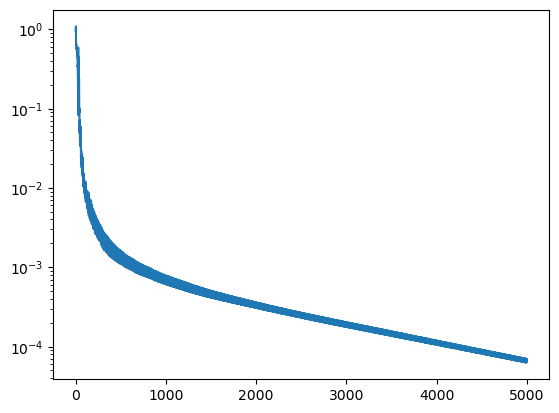

In [5]:
plt.plot(d_loss_list)
plt.yscale('log')

In [6]:
gan = GAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate)

d_loss_list = []
g_loss_list = []

# Train the Discriminator and Generator
for epoch in range(100):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        d_loss = gan.train_discriminator(signal_tensor, params_tensor, z)
        d_loss_list.append(d_loss)
    print(f"Epoch {epoch}, Discriminator loss: {d_loss}")


Epoch 0, Discriminator loss: 0.5722998380661011
Epoch 1, Discriminator loss: 0.25043636560440063
Epoch 2, Discriminator loss: 0.12622447311878204
Epoch 3, Discriminator loss: 0.051160458475351334
Epoch 4, Discriminator loss: 0.032664284110069275
Epoch 5, Discriminator loss: 0.021131392568349838
Epoch 6, Discriminator loss: 0.025515258312225342
Epoch 7, Discriminator loss: 0.0205144714564085
Epoch 8, Discriminator loss: 0.013226628303527832
Epoch 9, Discriminator loss: 0.00998636893928051
Epoch 10, Discriminator loss: 0.009945468977093697
Epoch 11, Discriminator loss: 0.008821764960885048
Epoch 12, Discriminator loss: 0.007402450777590275
Epoch 13, Discriminator loss: 0.007194550707936287
Epoch 14, Discriminator loss: 0.006827806122601032
Epoch 15, Discriminator loss: 0.005771579220890999
Epoch 16, Discriminator loss: 0.00645724032074213
Epoch 17, Discriminator loss: 0.007076999172568321
Epoch 18, Discriminator loss: 0.00498478626832366
Epoch 19, Discriminator loss: 0.004549791105091572

In [15]:
for epoch in range(500):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        #z = torch.randn(1, num_latent_variables, 1).to(device)
        g_loss = gan.train_generator(signal_tensor, z)
        d_loss = gan.train_discriminator(signal_tensor, params_tensor, z)
        g_loss_list.append(g_loss)
        d_loss_list.append(d_loss)
    print(f"Epoch {epoch}, Generator loss: {g_loss}, Discriminator loss: {d_loss}")

Epoch 0, Generator loss: 0.6553518176078796, Discriminator loss: 0.7012932300567627
Epoch 1, Generator loss: 0.7248415350914001, Discriminator loss: 0.6880601644515991
Epoch 2, Generator loss: 0.6484228372573853, Discriminator loss: 0.7209388613700867
Epoch 3, Generator loss: 0.6551143527030945, Discriminator loss: 0.7161864042282104
Epoch 4, Generator loss: 0.654058575630188, Discriminator loss: 0.7087373733520508
Epoch 5, Generator loss: 0.6727005839347839, Discriminator loss: 0.7049639225006104
Epoch 6, Generator loss: 0.6823297142982483, Discriminator loss: 0.7007737159729004
Epoch 7, Generator loss: 1.2063794136047363, Discriminator loss: 0.5413963794708252
Epoch 8, Generator loss: 0.36486077308654785, Discriminator loss: 0.859184741973877
Epoch 9, Generator loss: 0.840074360370636, Discriminator loss: 0.6640529632568359
Epoch 10, Generator loss: 0.7570613026618958, Discriminator loss: 0.6479033827781677
Epoch 11, Generator loss: 0.7277777194976807, Discriminator loss: 0.670715570

In [16]:
generator = gan.generator
generator.eval()

TS = Signal_Generator(num_sources=1, noise_amplitude=1)
test_data = TS.generating_signal()
params = TS.printing_parameters()

input_signal = test_data['Signal'].values
input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

with torch.no_grad():
    generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

print(params)
print(generated_params)

In [19]:
class WGAN():
    def __init__(self, dataset, num_latent_variables, lr, weight_clip):
        self.dataset = dataset
        self.num_latent_variables = num_latent_variables
        self.lr = lr
        self.weight_clip = weight_clip

        # Networks
        self.generator = Generator(in_channels=1, num_latent_variables=num_latent_variables, length=len(signal), num_parameters=len(params)).to(device)
        self.discriminator = Discriminator(input_channels=1, length=len(signal), num_parameters=len(params)).to(device)

        # Optimizers
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr)

    def wasserstein_loss(self, output_d, y):
        return torch.mean(output_d * y)
    
    def train_generator(self, signal_tensor, z):
        generated_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, generated_params)
        g_loss = -torch.mean(fake_output)

        self.optimizer_g.zero_grad()
        g_loss.backward()
        self.optimizer_g.step()

        return g_loss.item()
    
    def train_discriminator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z).detach()
        real_output = self.discriminator(signal_tensor, params_tensor)
        fake_output = self.discriminator(signal_tensor, fake_params)

        d_loss = -(torch.mean(real_output) - torch.mean(fake_output))

        self.optimizer_d.zero_grad()
        d_loss.backward()
        self.optimizer_d.step()

        # Weight clipping
        for p in self.discriminator.parameters():
            p.data.clamp_(-self.weight_clip, self.weight_clip)


        return d_loss.item()

In [21]:
wgan = WGAN(dataset, num_latent_variables=num_latent_variables, lr=learning_rate, weight_clip=0.01)


g_loss_list = []
d_loss_list = []

num_epochs = 500
num_critic = 5

for epoch in range(num_epochs):
    for _, (signal_tensor, params_tensor) in enumerate(train_loader):
        signal_tensor = signal_tensor.to(device)
        params_tensor = params_tensor.to(device)
        
        for _ in range(num_critic):
            z = torch.randn(signal_tensor.size(0), wgan.num_latent_variables, 1).to(device)
            d_loss = wgan.train_discriminator(signal_tensor, params_tensor, z)
        
        z = torch.randn(signal_tensor.size(0), wgan.num_latent_variables, 1).to(device)
        g_loss = wgan.train_generator(signal_tensor, z)
        
        g_loss_list.append(g_loss)
        d_loss_list.append(d_loss)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Generator loss: {g_loss}, Discriminator loss: {d_loss}")


Epoch 1/500, Generator loss: -0.5003039240837097, Discriminator loss: -0.002644360065460205
Epoch 2/500, Generator loss: -0.5002155303955078, Discriminator loss: -0.0032842159271240234
Epoch 3/500, Generator loss: -0.5036647319793701, Discriminator loss: 0.0011756420135498047
Epoch 4/500, Generator loss: -0.5031977891921997, Discriminator loss: 0.0004311203956604004
Epoch 5/500, Generator loss: -0.5038115382194519, Discriminator loss: -0.0013865232467651367
Epoch 6/500, Generator loss: -0.5044497847557068, Discriminator loss: -0.00036263465881347656
Epoch 7/500, Generator loss: -0.5046750903129578, Discriminator loss: -0.00028449296951293945
Epoch 8/500, Generator loss: -0.5039489269256592, Discriminator loss: -0.0009512901306152344
Epoch 9/500, Generator loss: -0.5034221410751343, Discriminator loss: -0.0016151666641235352
Epoch 10/500, Generator loss: -0.503147542476654, Discriminator loss: -0.002013683319091797
Epoch 11/500, Generator loss: -0.5039631128311157, Discriminator loss: -

In [26]:
generator = wgan.generator
generator.eval()

for i in range(10):
    TS = Signal_Generator(num_sources=1, noise_amplitude=1)
    test_data = TS.generating_signal()
    params = TS.printing_parameters()

    input_signal = test_data['Signal'].values
    input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    print(params)
    print(generated_params)

[6.684454710500766, 0.2785319288485978, 0.9111084160949837]
[ 8.713801   -0.14443322  3.5694919 ]
[10.936496259803521, 0.2981078136250689, 0.03876672843272887]
[ 7.270414   -0.79827875  3.768388  ]
[10.215128402431985, 0.3925196061055872, 0.9322377266462796]
[ 8.614659   -0.47095633  3.8795588 ]
[10.791707429527968, 0.33887817237630685, 0.27712219355009865]
[ 8.608505   -0.18909442  3.886261  ]
[7.7862689190518175, 0.4057925059966937, 5.031714069836047]
[ 9.326688   -0.22190507  3.570914  ]
[10.306911124248657, 0.3847102181822575, 3.209721330044897]
[ 9.125465   -0.33485416  4.3714294 ]
[9.763407088603955, 0.4262137120658779, 0.909128988908456]
[ 7.8996453  -0.35099566  3.423662  ]
[10.333264513621586, 0.4328789376296332, 6.214777862046191]
[9.233693   0.30373397 4.7812138 ]
[10.665680283177151, 0.4382246718617583, 5.7737907865639]
[8.732942   0.24169317 3.5212786 ]
[8.859682325831159, 0.33792174466427066, 4.5196306327616265]
[ 7.5417337  -0.32620895  3.1741993 ]
